In [ ]:
pip install smogn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import smogn
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from xgboost import XGBRegressor


In [ ]:
# Load the Excel file
df = pd.read_excel('/content/deduplicated_by_mode.xlsx')


In [ ]:
# Target calculation and cleanup
df["NCC_combined"] = df[["NCC-16-prevalence", "NCC-18-prevalence"]].mean(axis=1, skipna=True)
df = df.dropna(subset=["NCC_combined"]).copy()

drop_cols = [
    "Country", "Continent", "economy", "Sample size studied",
    'NCC-16-cases', 'NCC-18-cases', 'NCC-16-prevalence', 'NCC-18-prevalence',
    'Low CIN-16-cases', 'Low CIN-18-cases', 'High CIN-16-cases', 'High CIN-18-cases',
    'Low CIN-16-prevalence', 'Low CIN-18-prevalence', 'High CIN-16-prevalence', 'High CIN-18-prevalence',
    'ICC - 16 - any - cases', 'ICC - 16 - SCC - cases', 'ICC - 16 - ADC - cases',
    'ICC - 18 - any - cases', 'ICC - 18 - SCC - cases', 'ICC - 18 - ADC - cases',
    'ICC - 16 - any - prevalence', 'ICC - 16 - SCC - prevalence', 'ICC - 16 - ADC - prevalence',
    'ICC - 18 - any - prevalence', 'ICC - 18 - SCC - prevalence', 'ICC - 18 - ADC - prevalence',
    'ICC prevalence', 'High CIN prevalence', 'Low CIN prevalence'
]
df.drop(columns=drop_cols, errors='ignore', inplace=True)


In [ ]:
def convert_screening_year(value):
    if pd.isnull(value): return np.nan
    if isinstance(value, str) and value.strip().lower() in ["not started", "unknown"]:
        return 0
    try: return int(value)
    except: return np.nan

df["Screening_Start_Year"] = df["Start of Screening coverage (year)"].apply(convert_screening_year)

circumcision_col = "Male circumcision (WHO 2007)"
if circumcision_col in df.columns:
    df["Male circumcision category"] = df[circumcision_col].map({"<20": "Low", "20-80": "Medium", ">80": "High"})
    df.drop(columns=[circumcision_col], inplace=True)


In [ ]:
df["TB_Incidence_Percent"] = (df["Incidence of TB"] / df["Population estimate"]) * 100
df["Disease_Incidence_Score"] = df[["TB_Incidence_Percent", "Hypertension", "Diabetes Prevalence"]].apply(
    lambda x: (x - x.min()) / (x.max() - x.min()), axis=0).mean(axis=1)

sti_cols = ['STI_SyphilisRate_rateper100k_2021', 'STI_ChlamydialInfectionRate_rateper100k_2021', 'STDRates_GonococcalInfectionRate_rateper100k_2021']
df_sti_norm = df[sti_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
df['STI_Score'] = df_sti_norm.mean(axis=1)

df.drop(columns=["TB_Incidence_Percent", "Hypertension", "Diabetes Prevalence"] + sti_cols, errors='ignore', inplace=True)


In [ ]:
X_all = df.drop(columns=["NCC_combined"])
y_all = df["NCC_combined"]

numeric_cols = X_all.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X_all.select_dtypes(include=["object", "bool", "category"]).columns.tolist()

X_all[categorical_cols] = X_all[categorical_cols].astype(str)

preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), numeric_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(drop="first", sparse_output=False, handle_unknown='ignore'))
    ]), categorical_cols)
])

X_preprocessed = preprocessor.fit_transform(X_all)


In [ ]:
lasso = LassoCV(cv=5, random_state=42, max_iter=1500000).fit(X_preprocessed, y_all)
selector = SelectFromModel(lasso, threshold=-np.inf, prefit=True)
selected_mask = selector.get_support()

num_features = preprocessor.named_transformers_['num']['scaler'].get_feature_names_out(numeric_cols)
cat_features = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_cols)
all_features = np.concatenate([num_features, cat_features])
selected_features = all_features[selected_mask]

if len(selected_features) == 0:
    raise ValueError("❌ Lasso selected zero features. Relax the threshold or inspect data quality.")

print(f"\n✅ Total selected features after Lasso: {len(selected_features)}")
print("Selected features:")
print(list(selected_features))



✅ Total selected features after Lasso: 60
Selected features:
['Anemia prevalence among women of reproductive age (% of women ages 15-49)', 'Anemia prevalence among non-pregnant women (% of women ages 15-49)', 'Physicians per 1,000 people', 'Anemia prevalence among pregnant women (%)', 'Mean targeted age', 'Population estimate', 'Smoking Prevalence (Current smoking prevalence females, 2016)', 'Total Fertility rate (2017)', 'Contraception use (updated 2019)', 'HIV Prevalence (in adults)', 'Sexual Initiation age', 'Mean marital age', 'Multiple pregnancies (%age)', 'Condom Use', 'HPV vaccination introduction', 'Age adjusted incidence (standardized rates)', 'Number of deaths (all ages, 2021)', 'Mortality rates (age standardized)', 'Human Development Index (HDI)', 'Life expectancy at birth', 'Expected years of schooling', 'Mean years of schooling', 'Gross national income (GNI) per capita', 'Incidence of TB', 'HPV Vaccine', 'Coverage ever screened of women 30 - 49 years (%)', 'Coverage in la

In [ ]:
# Create DataFrame from Lasso-selected features
X_selected_df = pd.DataFrame(X_preprocessed[:, selected_mask], columns=selected_features)

# Sanitize column names
X_selected_df.columns = [col.replace('[', '').replace(']', '').replace('<', '').replace('>', '')
                         .replace('(', '').replace(')', '').replace('%', 'percent').replace(' ', '_')
                         for col in X_selected_df.columns]

# PCA: retain 95% of the variance
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_selected_df)

print(f"\n📉 PCA reduced the dimensions from {X_selected_df.shape[1]} to {X_pca.shape[1]}")



📉 PCA reduced the dimensions from 60 to 19


In [ ]:
# Combine with target
df_stable = pd.concat([pd.DataFrame(X_pca), y_all.reset_index(drop=True)], axis=1)

# Apply SMOGN
np.random.seed(42)
random.seed(42)

df_smogn = smogn.smoter(
    data=df_stable,
    y="NCC_combined",
    k=5,
    samp_method='extreme',
    rel_thres=0.8629513970420527
)


synth_matrix: 100%|##########| 14/14 [00:00<00:00, 32.24it/s]


In [ ]:
X = df_smogn.drop(columns=["NCC_combined"])
y = df_smogn["NCC_combined"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
final_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_estimators=200,
    max_depth=4,
    learning_rate=0.010432920541221915,
    subsample=0.858663879924028,
    colsample_bytree=0.7469584920796172,
    gamma=2.85974989985308,
    reg_alpha=2.4259824683569735,
    reg_lambda=4.906137291714221
)

final_model.fit(X_train, y_train)
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)


In [ ]:
def relative_rmse(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse / np.mean(y_true)

print("\n🔧 Used Hyperparameters:")
print(final_model.get_params())

print("\n📊 Performance Metrics:")
print(f"Train R²: {r2_score(y_train, y_train_pred):.4f}")
print(f"Test R²:  {r2_score(y_test, y_test_pred):.4f}")
print(f"Train MSE: {mean_squared_error(y_train, y_train_pred):.4f}")
print(f"Test MSE:  {mean_squared_error(y_test, y_test_pred):.4f}")
print(f"Train Relative RMSE: {relative_rmse(y_train, y_train_pred):.4f}")
print(f"Test Relative RMSE:  {relative_rmse(y_test, y_test_pred):.4f}")



🔧 Used Hyperparameters:
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.7469584920796172, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 2.85974989985308, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.010432920541221915, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 4, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 200, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': 2.4259824683569735, 'reg_lambda': 4.906137291714221, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.858663879924028, 'tree_method': None, 'validate_parameters': None, 'verbosity': None

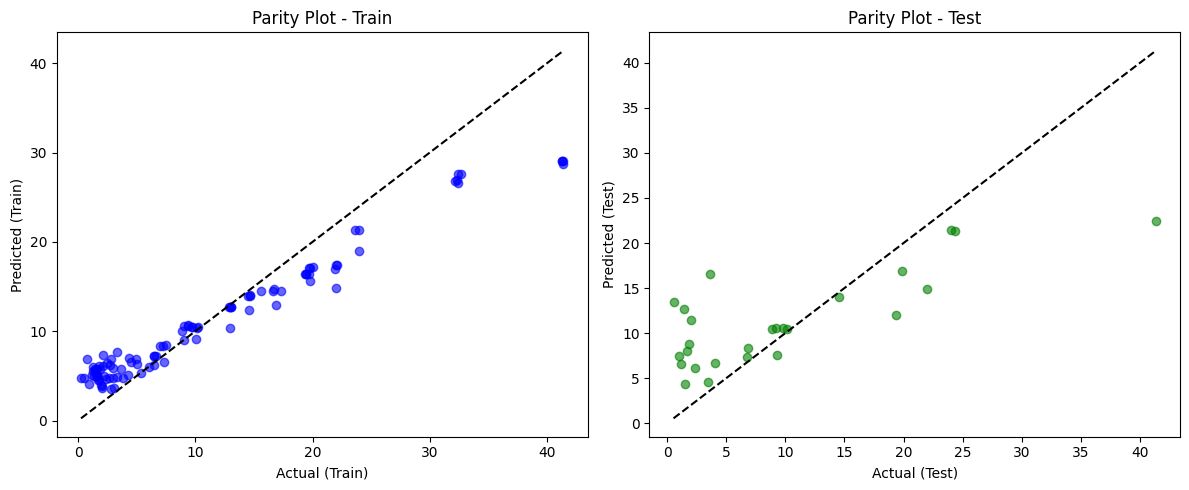

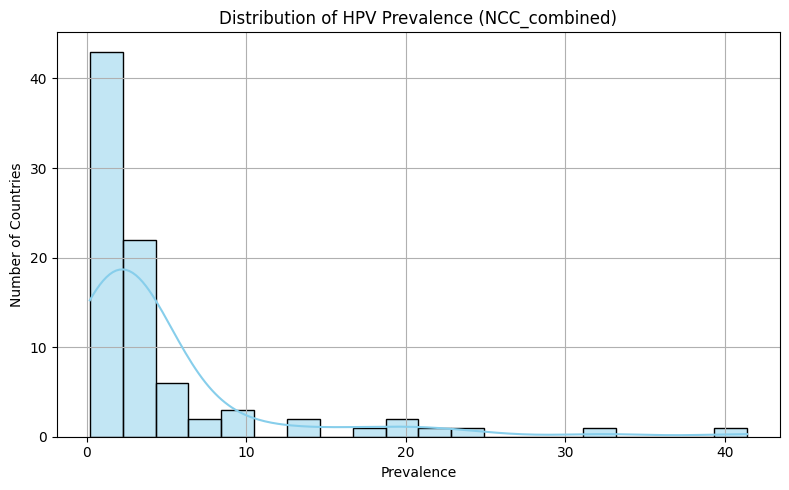

In [ ]:
# Parity Plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, color='blue', alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--')
plt.xlabel("Actual (Train)")
plt.ylabel("Predicted (Train)")
plt.title("Parity Plot - Train")

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, color='green', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel("Actual (Test)")
plt.ylabel("Predicted (Test)")
plt.title("Parity Plot - Test")
plt.tight_layout()
plt.show()

# Target Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df["NCC_combined"], bins=20, kde=True, color='skyblue', edgecolor='black')
plt.title("Distribution of HPV Prevalence (NCC_combined)")
plt.xlabel("Prevalence")
plt.ylabel("Number of Countries")
plt.grid(True)
plt.tight_layout()
plt.show()
